<a href="https://colab.research.google.com/github/Zahra-Ferdous/Thesis_Human_Action_Recognition_from_Depth_Video/blob/main/czu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn
import math
%matplotlib inline
import os
import time

from numba.core.cgutils import if_likely
#from os.path import exists
import os.path 

import cv2
import sklearn
import scipy.io as sio
from numba import jit
from math import factorial, log
from sklearn.neighbors import KDTree
from scipy.signal import periodogram, welch
from astropy.timeseries import LombScargle
from scipy.io import loadmat
import re
import itertools


import imageio
from skimage import feature


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## For trialing purpose. Do not run these cells

In [3]:
def spectral_entropy(x, sf=100, method='fft', nperseg=None, normalize=False,axis=-1):
  
    x = np.asarray(x)
    #sf = np.array(sf, dtype=np.float64)
    # Compute and normalize power spectrum
    if method == 'fft':
        _, psd = periodogram(x, sf, axis=axis)
    elif method == 'welch':
        _, psd = welch(x, sf, nperseg=nperseg, axis=axis)
    psd_norm = psd / psd.sum(axis=axis, keepdims=True)
    se = -(psd_norm * np.log2(psd_norm)).sum(axis=axis)
    if normalize:
        se /= np.log2(psd_norm.shape[axis])
    return se

In [17]:
from astropy.utils.iers.iers import ScienceState
path = '/content/drive/MyDrive/Colab Notebooks/CZU Sensor/'
filename = 'cx_a1_t1'
Sen = sio.loadmat(path+filename)

In [12]:
sen = Sen['sensor']
sen.shape
sen0 = sen[0][0]
sen0.shape
sen1 = sen[1][0]
sen1.shape

(3471, 7)

In [14]:
type(sen1)
df = pd.DataFrame(sen1, columns = ['a_x','a_y','a_z','g_x','g_y','g_z','ts'])

In [15]:
df.head()

,a_x,a_y,a_z,g_x,g_y,g_z,ts
0,-0.074219,-0.996826,0.128418,3.660099,-0.854023,-0.488013,1.048094e+11
1,-0.073486,-0.996582,0.130371,3.477094,-1.037028,-0.366010,1.048094e+11
2,-0.074707,-0.996582,0.137451,3.233087,-0.610016,-0.305008,1.048094e+11
3,-0.077637,-0.997803,0.134521,3.172086,-0.610016,-0.244007,1.048094e+11
4,-0.080811,-0.999512,0.137939,3.111084,-0.549015,-0.366010,1.048094e+11


# Run from here

In [28]:
def statf(df,c):
    col = 'a_'+c
    col1 = 'g_'+c
    # acc
    mean_a = df[col].mean()
    var_a = df[col].var()
    std_a = df[col].std()
    mx_a = df[col].max()
    mn_a = df[col].min()
    rng_a = mx_a-mn_a
    #mode = df[col].mode()
    #n_z = ((df[col][:-1] * df[col][1:]) < 0).sum()
    
    #gyro
    mean_g = df[col1].mean()
    var_g = df[col1].var()
    std_g = df[col1].std()
    mx_g = df[col1].max()
    mn_g = df[col1].min()
    rng_g = mx_g-mn_g
    
    f_a=abs(np.fft.fft(df[col]))
    f_g=abs(np.fft.fft(df[col1]))
    num=df.shape[0]
    
    #fs=1./diff(t)
    
    freq = [i / num for i in list(range(num))]
    
    spectrum_a = f_a.real*f_a.real+f_a.imag*f_a.imag
    dc_comp_a = spectrum_a[0]
    spectrum_a = np.multiply(spectrum_a,spectrum_a)  # get the sectrum square
    spec_energy_a = spectrum_a.sum()/num
    
    spectrum_g = f_g.real*f_g.real+f_g.imag*f_g.imag
    dc_comp_g = spectrum_g[0]
    spectrum_g = np.multiply(spectrum_g,spectrum_g)  # get the sectrum square
    spec_energy_g = spectrum_g.sum()/num
    
    # spectral entropy
    
#     df['ts_shifted'] = df['ts'].shift(1)
#     freq1=df['ts'] - df['ts_shifted']
#     freq1 = freq1.dropna(axis = 0, how = 'all')

    '''
    tim = df['ts'][df.shape[0]-1] - df['ts'][0]
    freq1 = df.shape[0]/tim
    mean_freq = np.mean(freq1)
    #mean_freq = 1/np.mean(freq1)
    spec_entropy_a = spectral_entropy(df[col], mean_freq, method='fft', nperseg=None, normalize=False,axis=-1)
    spec_entropy_g = spectral_entropy(df[col1], mean_freq, method='fft', nperseg=None, normalize=False,axis=-1)
    '''
    # poer spectral density using LombScargle Periodogram
    
    frequency_a, power_a = LombScargle(df['ts'], df[col]).autopower()

    max_psd_a = np.max(power_a)
    min_psd_a = np.min(power_a)
    min_max_psd_a = min_psd_a/max_psd_a
    
    max_xas_a = np.sqrt(max_psd_a)
    min_xas_a = np.sqrt(min_psd_a)
    min_max_xas_a = min_xas_a/max_xas_a
    
    frequency_g, power_g = LombScargle(df['ts'], df[col1]).autopower()

    max_psd_g = np.max(power_g)
    min_psd_g = np.min(power_g)
    min_max_psd_g = min_psd_g/max_psd_g
    
    max_xas_g = np.sqrt(max_psd_g)
    min_xas_g = np.sqrt(min_psd_g)
    min_max_xas_g = min_xas_g/max_xas_g

    return np.array([mean_a ,var_a ,std_a ,mx_a ,mn_a ,rng_a ,dc_comp_a ,spec_energy_a, 
                     max_psd_a ,min_psd_a ,min_max_psd_a ,max_xas_a ,min_xas_a ,min_max_xas_a ,
                    mean_g ,var_g ,std_g ,mx_g ,mn_g ,rng_g ,dc_comp_g ,spec_energy_g,
                     max_psd_g ,min_psd_g ,min_max_psd_g ,max_xas_g ,min_xas_g ,min_max_xas_g ])
    

In [33]:
def sensor_feature_extraction(sen_matfile, selected_features):
  #Sen = sio.loadmat(path+filename)['sensor']          # (10,0)
  Sen = sen_matfile['sensor']
  sen_pos = []
  for sen_no in range(10):
    sen = Sen[sen_no][0]                              # (no_of_rows , 7)

    df = pd.DataFrame(sen, columns = ['a_x','a_y','a_z','g_x','g_y','g_z','ts'])

    #----------------------------------------------------------------------------------------------
    x = statf(df,'x')
    y = statf(df,'y')
    z = statf(df,'z')
    df['a_m'] =  np.sqrt(df['a_x']*df['a_x']+df['a_y']*df['a_y']+df['a_z']*df['a_z'])
    df['g_m'] =  np.sqrt(df['g_x']*df['g_x']+df['g_y']*df['g_y']+df['g_z']*df['g_z'])
    m = statf(df,'m')
    
    sen_feat_i = np.concatenate((x, y, z, m), axis = 0)  
    #print(f"shape of individual sensor features = {sen_feat_i.shape}")

    if(sen_no==0):
        sen_feat = sen_feat_i
    else:
        sen_feat = np.concatenate([sen_feat,sen_feat_i],axis=0)

    #------------------------------------------------------------------------------------------------
  #print(f"shape of 10 sensor features = {sen_feat.shape}")
  #--------------------------------------------------------------------------------------------------
  sen_names  = ['0_','1_','2_','3_','4_','5_','6_','7_','8_','9_']

  col = ['mean','var','std','max','min','range','dc_comp','spec_energy','max_psd','min_psd','min_max_psd','max_xas','min_xas','min_max_xas']
  axis = ['_a_x','_g_x','_a_y','_g_y','_a_z','_g_z','_a_m','_g_m']

  col_name = []

  for s in sen_names:
      for x in axis:
          for (c) in (col):
              col_name.append(s+c+x)
  #print(f"number of overall features:{len(col_name)}")

  ser = pd.Series(sen_feat, index = col_name);

  # return only the selected features
  feature_list = ser[ser.index.isin(selected_features)]

  return feature_list

In [35]:
res = sensor_feature_extraction(Sen, ['0_mean_a_x','0_mean_g_y','9_min_max_xas_g_m'])

In [36]:
res.keys()

Index(['0_mean_a_x', '0_mean_g_y', '9_min_max_xas_g_m'], dtype='object')

In [37]:
res

0_mean_a_x           0.084407
0_mean_g_y          -1.097520
9_min_max_xas_g_m    0.000045
dtype: float64

## For DMM Sobel

In [49]:
def masked(img):
  x = np.logical_and((img>=70), (img<=90)).astype(int)
  return x

#sobel 
skernelx = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
skernely = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])

def sobel_filtered_x(d):
  #d = masked(d)
  d = d.astype('float32')
  im = cv2.resize(d, dsize=(227,227))
  
  imx = cv2.filter2D(im, -1, skernelx)
  
  return imx

def get_dmm(d,ch='s'):   # param: a 

  start = time.time()

  dep, ht, wd = d.shape
  F = np.zeros((227,227))

  for i in range(dep):

    im = np.array(d[i])
    im = cv2.resize(im, dsize=(227,227))
    im = masked(im)
    
    im = sobel_filtered_x(im)
    if(i>0):
      F = np.add( F, np.absolute( np.subtract( im, front_pre ) ) )
    
    front_pre = im

  end = time.time()
  el_time = end - start
  print('dmm time')
  print(el_time)

  return F

In [54]:
def depth_map_preprocess(d_mat):
  d = d_mat['depth']
  frame, h, w = d.shape
  print(f"earlier shape = {d.shape}")
  if (frame < 100) :
    d = np.concatenate(( d, d[:(100-frame)] ), axis=0)

  #frame = d.shape[0]
  res = []
  print(f"later shape = {d.shape}")
  for k in range(0,100,4):
    res.append(np.array(d[k][50:350,100:400]))
    #d[k] = cv2.resize(d[k], dsize=(227,227))
  res = np.array(res)
  dmm = get_dmm(res,'s')
  return dmm
  # [50:350,100:400]

In [55]:
path = '/content/drive/MyDrive/CZU-MHAD/depth_mat/cx_a10_t1.mat'
d_mat = sio.loadmat(path)
dmm = depth_map_preprocess(d_mat)

earlier shape = (132, 424, 512)
later shape = (132, 424, 512)
dmm time
0.008897781372070312


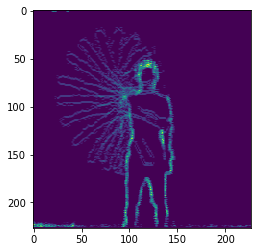

In [56]:
plt.imshow(dmm,interpolation = 'nearest')
plt.show()

In [57]:
dmm.shape


(227, 227)